In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil

Importing Images datasets from Github

In [ ]:
!kaggle datasets download -d eeshawn/flickr30k

!unzip flickr30k.zip

Dataset URL: https://www.kaggle.com/datasets/eeshawn/flickr30k
License(s): other
 94% 3.83G/4.08G [01:36<00:06, 42.6MB/s]

Importing text data from Github

In [ ]:
!wget https://raw.githubusercontent.com/Ramkanc/IIITHgrp20/refs/heads/main/Flickr30k.csv

--2025-02-22 07:37:23--  https://raw.githubusercontent.com/Ramkanc/IIITHgrp20/refs/heads/main/Flickr30k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12425106 (12M) [text/plain]
Saving to: ‘Flickr30k.csv’

Flickr30k.csv       100%[===================>]  11.85M  27.6MB/s    in 0.4s    

2025-02-22 07:37:24 (27.6 MB/s) - ‘Flickr30k.csv’ saved [12425106/12425106]



In [ ]:
image_data_location = "/content/flickr30k_images"
caption_data_location = "/content/Flickr30k.csv"

Delete zip files and keep unzipped folders and files only

It seems some images are not good , Collecting all the images which are opening.

In [ ]:
#  to collect images from image_data_location folder which are getting opened

images_good = []
# iterate over all the files in the image_data_location
for filename in os.listdir(image_data_location):
  # check if the file is an image
  if filename.endswith(('.jpg', '.jpeg', '.png')):
    # open the image
    try:
      img = Image.open(os.path.join(image_data_location, filename))
      images_good.append(filename.split(".")[0]) #append to a list
    except IOError:
      print("Unable to open image:", filename)

# Now you have a list 'images' containing opened image objects from the specified directory.
# You can further process these images as needed.
print(f"Loaded {len(images_good)} images")

Loaded 31783 images


In [ ]:
images_good[:5]

['2192547226', '2290936635', '4785739399', '3081363964', '3301859683']

Collecting the dataframe from raw data

In [ ]:
raw_df = pd.read_csv(caption_data_location, sep=",", header=0)#, names=['image','captions'])

In [ ]:
raw_df.head()

image                                            caption
0  1000092795   Two young guys with shaggy hair look at their...
1  1000092795   Two young , White males are outside near many...
2  1000092795   Two men in green shirts are standing in a yard .
3  1000092795       A man in a blue shirt standing in a garden .
4  1000092795            Two friends enjoy time spent together .

In [ ]:
# The below code is to clear out the part post the image name ex: 1000268201_693b08cb0e.jpg#0	 --> 1000268201_693b08cb0e.jpg
raw_df['image'] = raw_df['image'].astype(str).str.strip()

Compare good images list with dataframe adn identifying the indexes of bad images

In [ ]:
#  to find the df[image] rows not in images_good list

#indices_not_in_list = df.index[~df['image'].isin(images_good)].tolist()
indices_not_in_list = []
for index, image_name in raw_df['image'].items():

    if image_name not in images_good:
        print(image_name)
        indices_not_in_list.append(index)
#
#df = df[~df['image'].isin(images_good)].reset_index(drop=True)



In [ ]:
len(indices_not_in_list)

0

Dropping bad images captions from captions dataframe

In [ ]:
df = raw_df.drop(indices_not_in_list, inplace=False)

In [ ]:
print(df.head())
print(f"raw df shape - {raw_df.shape}")
print(f"new df shape - {df.shape}")

        image                                            caption
0  1000092795   Two young guys with shaggy hair look at their...
1  1000092795   Two young , White males are outside near many...
2  1000092795   Two men in green shirts are standing in a yard .
3  1000092795       A man in a blue shirt standing in a garden .
4  1000092795            Two friends enjoy time spent together .
raw df shape - (158914, 2)
new df shape - (158914, 2)


Find out the caption which is having maximum words

In [ ]:
# to find the maximum words string from df['captions'] column

df['word_count'] = df['caption'].apply(lambda x: len(x.split()))
max_words_string = df.loc[df['word_count'].idxmax(), 'caption']
print(f"The string with the maximum words is:\n{max_words_string}")
print(f"the length of the string is {len(max_words_string.split())}")


The string with the maximum words is:
 A man wearing a helmet , red pants with white stripes going down the sides and a white and red shirt is on a small bicycle using only his hands while his legs are up in the air , while another man wearing a light blue shirt with dark blue trim and black pants with red stripes going up the sides is standing nearby , gesturing toward the first man and holding a small figurine of one of the seven dwarves .
the length of the string is 82


randomly printing an image and caption

/content/flickr30k_images/1000268201.jpg


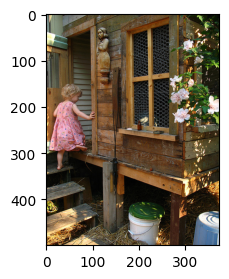

Caption -  A little girl in a pink dress going into a wooden cabin .
Caption -  A little girl climbing the stairs to her playhouse .
Caption -  A little girl climbing into a wooden playhouse 
Caption -  A girl going into a wooden building .
Caption -  Someone in a blue shirt and hat is standing on stair and leaning against a window .


In [ ]:
data_idx = 11
image_name = df.iloc[data_idx,0]
# print(image_name)
image_path = image_data_location + "/" + image_name+".jpg"
print(image_path)
img = mpimg.imread(image_path)
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.show()

for i in range(data_idx, data_idx+5):
    print(f"Caption - {df.iloc[i,1]}")

Spacy library :
spaCy is used for Tokenization: Breaks down text into individual words or tokens.








In [ ]:
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

In [ ]:
spacy_eng = spacy.load('en_core_web_sm')
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

Class to add special tokens , tokenization and preprocessing

In [ ]:
class Vocabulary:
    def __init__(self,freq_threshold):
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self,sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]



In [ ]:
v = Vocabulary(freq_threshold=1) #was1
v.build_vocab(["This is a new city"])
print(v.stoi)
print(v.itos)
print(v.numericalize("This is a new city"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'new': 7, 'city': 8}
{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'this', 5: 'is', 6: 'a', 7: 'new', 8: 'city'}
[4, 5, 6, 7, 8]


Dataset preparation
Images and Captions dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self,root_dir,captions_df,transform=None, freq_threshold=5): # was freq_threshold=5
        self.root_dir = root_dir
        self.df = captions_df


        self.transform = transform
        self.imgs = self.df["image"] .astype(str) + ".jpg"
        self.captions = self.df["caption"]

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]

        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        #print(f"caption - {caption}")

        return img, torch.tensor(caption_vec)

In [ ]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [ ]:
def show_image(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
# testing the dataset
dataset = CustomDataset(
        root_dir = image_data_location,
        captions_df = df,
        transform = transforms
)

In [ ]:
v = dataset.vocab

In [ ]:
import pickle

In [ ]:
with open('vocabulary_30.pkl', 'wb') as f:
    pickle.dump(dataset.vocab, f)

In [ ]:
def token_to_sentence(dataset, caps):
  special_strings = ["<SOS>", "<UNK>", "<EOS>","<PAD>"]
  sen = [dataset.vocab.itos[token] for token in caps.tolist()]
  sen = [token for token in sen if token not in special_strings]
  return " ".join(sen)

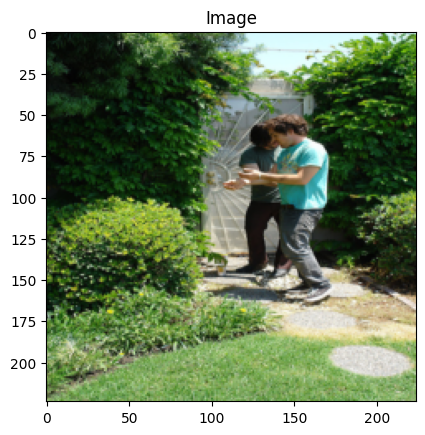

Token : tensor([   1,    5,    8,   25,  160,   28, 2122,   80,  158,   27,   60,  260,
          23,  467,  106,    4,   14,  366,    6,    2])
Sentence: 
  two young guys with shaggy hair look at their hands while hanging out in the yard .


In [ ]:
img, caps = dataset[0]
show_image(img,"Image")

print("Token :", caps)
print("Sentence: ")
sen = token_to_sentence(dataset, caps)
print(sen)
# sen = [dataset.vocab.itos[token] for token in caps.tolist()]
# special_strings = ["<SOS>", "<UNK>", "<EOS>"]
# sen = [token for token in sen if token not in special_strings]
# print(" ".join(sen))

Collate function in a PyTorch

1) Collate Images: Combine a batch of images into a single tensor.

2) Pad Captions: Pad captions to a uniform length using a special padding token.

In [ ]:
class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
#         print(f"shape - {(imgs)}")
#         print("----"*22)
        imgs = torch.cat(imgs,dim=0)
#         print(f"shape - {imgs}")
#         print("------")
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

 create train, test and validation

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

test_indexes = test_df.index.tolist()
print(test_indexes)
# Reset indices
train_df = train_df.reset_index(drop=True)  # Reset index for train_df
val_df = val_df.reset_index(drop=True)    # Reset index for val_df
test_df = test_df.reset_index(drop=True)   # Reset index for test_df

# Create datasets
train_dataset = CustomDataset(root_dir=image_data_location, captions_df=train_df, transform=transforms)
val_dataset = CustomDataset(root_dir=image_data_location, captions_df=val_df, transform=transforms)
test_dataset = CustomDataset(root_dir=image_data_location, captions_df=test_df, transform=transforms)

[138301, 1325, 61069, 113573, 22387, 66672, 37791, 82275, 156669, 101729, 49082, 43738, 144607, 108785, 93549, 60807, 69105, 12932, 20166, 103057, 56814, 1045, 9261, 86956, 126105, 80158, 112205, 48568, 25987, 44243, 132637, 57231, 145841, 148783, 73217, 139369, 25427, 138811, 55024, 116757, 81642, 91117, 81639, 26391, 15666, 156265, 156329, 92428, 6827, 149140, 51390, 157235, 14400, 67869, 98332, 125303, 90043, 154952, 6552, 58895, 62994, 59654, 96061, 12072, 117489, 106047, 32352, 19112, 99243, 10407, 108244, 126290, 139806, 129491, 27346, 59773, 42107, 113295, 115214, 139426, 29170, 128075, 131721, 142370, 12619, 44030, 125564, 136032, 82449, 107601, 140495, 65255, 101162, 139157, 70351, 134738, 113784, 28027, 51051, 1002, 272, 47414, 145532, 40465, 140857, 138370, 25798, 78321, 133254, 35610, 100357, 49694, 50887, 157035, 30321, 63855, 18842, 114835, 50958, 6454, 125965, 24443, 26860, 28006, 78148, 30023, 71592, 103395, 122773, 45299, 120206, 156794, 5855, 155471, 45403, 65561, 370

Creating Dataloaders with batches

In [ ]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 35 #Was 4
NUM_WORKER = 2 #was 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

Creating Train Val and Test dataloaders

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=False,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=False,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)

Below code is to understand way of working of the  dataloader

In [ ]:
#generating the iterator from the dataloader
# dataiter = iter(data_loader)

# #getting the next batch
# batch = next(dataiter)

# #unpacking the batch
# images, captions = batch

# #showing info of image in single batch
# for i in range(BATCH_SIZE):
#     img,cap = images[i],captions[i]
#     #print(f"captions - {captions[i]}")
#     caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
#     eos_index = caption_label.index('<EOS>')
#     caption_label = caption_label[1:eos_index]
#     caption_label = ' '.join(caption_label)
#     show_image(img,caption_label)
#     plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

Model Architecture of Encoder and Decoder with caption generation method

Need to modify this to CLIP model with self attention

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self,embed_size):
        super(EncoderCNN,self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)

    def forward(self,images):
        features = self.resnet(images)
#
        features = features.view(features.size(0),-1)
#
        features = self.embed(features)
#
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(DecoderRNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self,features, captions):
        # vectorize the caption
#
        embeds = self.embedding(captions[:,:-1])
#
        x = torch.cat((features.unsqueeze(1),embeds),dim=1)
#
        x,_ = self.lstm(x)
#
        x = self.fcn(x)
#
        return x

    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None): #hidden=None
        # Inference part
        # Given the image features generate the captions

        batch_size = inputs.size(0)

        captions = []

        if hidden is None:
          hidden = (torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(inputs.device),
                    torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(inputs.device))

         # Ensure inputs is 3D: [batch_size, 1, embed_size]
        inputs = inputs.unsqueeze(1)  # Add sequence length = 1

        for i in range(max_len):

            output, hidden = self.lstm(inputs, hidden)  # LSTM expects 3D input
            output = self.fcn(output.squeeze(1))  # Shape: [batch_size, vocab_size]
            #output = output.view(batch_size,-1)



            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(1)) # Shape: [batch_size, 1, embed_size]


        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]


class EncoderDecoder(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(EncoderDecoder,self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Hyperparameters
embed_size = 512 #400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 2

In [ ]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


In [ ]:
#import nltk
#nltk.download('punkt')  # Download data for tokenization
#from nltk.translate.bleu_score import sentence_bleu
#from nltk.translate.bleu_score import SmoothingFunction
# Ensure NLTK's tokenizer is downloaded (Run once)
#nltk.download('punkt')
#nltk.download('punkt_tab')

In [ ]:
!pip install nltk==3.8.1
!pip install rouge-score==0.1.2
!pip install jiwer==3.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=d10c70e39210552f3f275e003b35ab6d9d44ada4634020ce7ee9a5157e6f9f6c
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.1 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import jiwer
import matplotlib.pyplot as plt # Import for plotting
nltk.download('punkt')


# Ensure NLTK's tokenizer is downloaded (Run once)
#nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
special_tokens = ["<SOS>", "<UNK>", "<EOS>","<PAD>"]

In [ ]:
smoothie = SmoothingFunction().method4  # Choose a smoothing method

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []

print_every = 2000
for epoch in range(1, num_epochs + 1):
    # Training Loop
    model.train()
    epoch_train_loss = 0  # Accumulate loss for the current epoch
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image, captions = image.to(device), captions.to(device)
        optimizer.zero_grad()
        outputs = model(image, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Calculate and store the average training loss for the epoch
    avg_epoch_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_epoch_train_loss)
    print("Epoch: {} loss: {:.5f}".format(epoch, avg_epoch_train_loss))

    # Validation Loop
    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0  # Accumulate loss for the current epoch
        for val_image, val_captions in val_loader:
            val_image, val_captions = val_image.to(device), val_captions.to(device)
            outputs = model(val_image, val_captions)
            loss = criterion(outputs.view(-1, vocab_size), val_captions.view(-1))
            epoch_val_loss += loss.item()

        # Calculate and store the average validation loss for the epoch
        avg_epoch_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_epoch_val_loss)
        print("Epoch: {} Validation loss: {:.5f}".format(epoch, avg_epoch_val_loss))

# Print the collected losses
print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)

Epoch: 1 loss: 3.63591
Epoch: 1 Validation loss: 5.32478
Epoch: 2 loss: 3.00070
Epoch: 2 Validation loss: 5.63558
Epoch: 3 loss: 2.77810
Epoch: 3 Validation loss: 5.82962
Epoch: 4 loss: 2.64249
Epoch: 4 Validation loss: 5.95608
Epoch: 5 loss: 2.54253
Epoch: 5 Validation loss: 6.07822
Epoch: 6 loss: 2.46240
Epoch: 6 Validation loss: 6.15442
Epoch: 7 loss: 2.39484
Epoch: 7 Validation loss: 6.23262
Epoch: 8 loss: 2.33618
Epoch: 8 Validation loss: 6.30862
Epoch: 9 loss: 2.28374
Epoch: 9 Validation loss: 6.38359
Epoch: 10 loss: 2.23607
Epoch: 10 Validation loss: 6.44684
Epoch: 11 loss: 2.19165


KeyboardInterrupt: 

In [ ]:
print(f"Average train loss: {np.mean(train_losses)}")
print(f"Average validation loss: {np.mean(val_losses)}")

Average train loss: 2.591329755340635
Average validation loss: 6.035037089909784


In [ ]:
results_dict = {'train_losses': train_losses, 'val_losses': val_losses}

In [ ]:
results_df = pd.DataFrame(results_dict)

In [ ]:
results_df

train_losses  val_losses
0      3.635910    5.324779
1      3.000703    5.635582
2      2.778104    5.829616
3      2.642487    5.956085
4      2.542525    6.078224
5      2.462404    6.154422
6      2.394842    6.232615
7      2.336184    6.308617
8      2.283745    6.383592
9      2.236074    6.446839

In [ ]:
# Save the model
torch.save(model.state_dict(), 'resnet_lstm_30.pth')

In [ ]:
# prompt: provide code to download image_captioning_model.pth file from colab to local

#from google.colab import files
#files.download('image_captioning_model.pth')


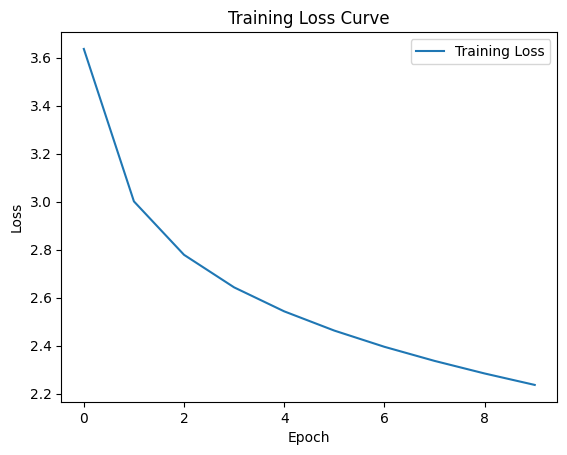

In [ ]:
import matplotlib.pyplot as plt
# Plot the training losses
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


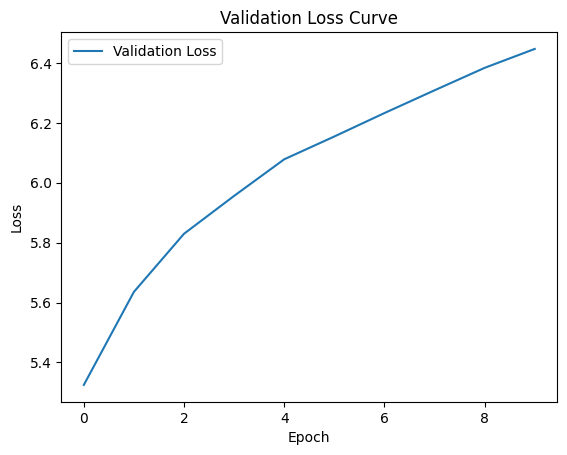

In [ ]:

# Plot the validation losses
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()
plt.show()


In [ ]:
test_indexes

[138301,
 1325,
 61069,
 113573,
 22387,
 66672,
 37791,
 82275,
 156669,
 101729,
 49082,
 43738,
 144607,
 108785,
 93549,
 60807,
 69105,
 12932,
 20166,
 103057,
 56814,
 1045,
 9261,
 86956,
 126105,
 80158,
 112205,
 48568,
 25987,
 44243,
 132637,
 57231,
 145841,
 148783,
 73217,
 139369,
 25427,
 138811,
 55024,
 116757,
 81642,
 91117,
 81639,
 26391,
 15666,
 156265,
 156329,
 92428,
 6827,
 149140,
 51390,
 157235,
 14400,
 67869,
 98332,
 125303,
 90043,
 154952,
 6552,
 58895,
 62994,
 59654,
 96061,
 12072,
 117489,
 106047,
 32352,
 19112,
 99243,
 10407,
 108244,
 126290,
 139806,
 129491,
 27346,
 59773,
 42107,
 113295,
 115214,
 139426,
 29170,
 128075,
 131721,
 142370,
 12619,
 44030,
 125564,
 136032,
 82449,
 107601,
 140495,
 65255,
 101162,
 139157,
 70351,
 134738,
 113784,
 28027,
 51051,
 1002,
 272,
 47414,
 145532,
 40465,
 140857,
 138370,
 25798,
 78321,
 133254,
 35610,
 100357,
 49694,
 50887,
 157035,
 30321,
 63855,
 18842,
 114835,
 50958,
 6454,
 

In [ ]:
df.head()

image                                            caption  word_count
0  1000092795   Two young guys with shaggy hair look at their...          17
1  1000092795   Two young , White males are outside near many...          11
2  1000092795   Two men in green shirts are standing in a yard .          11
3  1000092795       A man in a blue shirt standing in a garden .          11
4  1000092795            Two friends enjoy time spent together .           7

In [ ]:
dataframe = df.drop('word_count', axis=1)

In [ ]:
# Testing Loop
model.eval()  # Set the model to evaluation mode
test_loss = 0
bleu_scores = []
rouge_scores = []
wer_scores = []
smoothie = SmoothingFunction().method4
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
cntr = 0

with torch.no_grad():  # Disable gradient calculation during testing
    for images, captions in test_loader:
        images, captions = images.to(device), captions.to(device)
        inputs = captions[:, :-1]
        targets = captions[:, 1:]
        outputs = model(images, inputs)

        # Calculate loss
        outputs = outputs.view(-1, outputs.size(-1))
        targets = targets.reshape(-1)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        # Generate captions and calculate metrics
        for i in range(images.size(0)):

            oringinal_caption = dataframe.iloc[test_indexes[cntr]]['caption']#
            # Generate captions using the model
            generated_caption = model.decoder.generate_caption(
                model.encoder(images[i].unsqueeze(0)), vocab=dataset.vocab
            )

            # Convert generated caption to tokens
            generated_caption = [token for token in generated_caption if token not in special_tokens]
            generated_caption = " ".join(generated_caption)
            reference_caption = token_to_sentence(test_dataset,captions[i])



            # Calculate BLEU-4 score
            generated_tokens = nltk.word_tokenize(generated_caption.lower())
            reference_tokens = nltk.word_tokenize(reference_caption.lower())
            bleu4 = sentence_bleu([reference_tokens], generated_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
            bleu_scores.append(bleu4)

            # Calculate ROUGE scores
            rouge = scorer.score(reference_caption, generated_caption)
            rouge_scores.append(rouge)

            # Calculate WER score
            wer = jiwer.wer(reference_caption, generated_caption)
            wer_scores.append(wer)

            if cntr < 16:
              # Plot image with captions (reduced size)
              img_np = images[i].cpu().numpy().transpose(1, 2, 0)
              img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
              plt.figure(figsize=(3, 3))  # Adjust size as needed
              plt.imshow(img_np)
              plt.title(f"Generated: {generated_caption}\nReference: {oringinal_caption}", fontsize=9)
              plt.axis('off')
              plt.show()
              print("-" * 50)

            cntr += 1

# Calculate average scores
avg_test_loss = test_loss / len(test_loader)
avg_bleu_score = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
avg_rouge_scores = {k: sum([s[k].fmeasure for s in rouge_scores]) / len(rouge_scores) for k in ['rouge1', 'rouge2', 'rougeL']} if rouge_scores else {k: 0 for k in ['rouge1', 'rouge2', 'rougeL']}
avg_wer_score = sum(wer_scores) / len(wer_scores) if wer_scores else 0

# Print results
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Average BLEU-4 Score: {avg_bleu_score:.4f}")
print(f"Average ROUGE Scores: {avg_rouge_scores}")
print(f"Average WER Score: {avg_wer_score:.4f}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("Resnet LSTM scores")
print("="*25)
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Average BLEU-4 Score: {avg_bleu_score:.4f}")
print(f"Average ROUGE Scores: {avg_rouge_scores}")
print(f"Average WER Score: {avg_wer_score:.4f}")

Resnet LSTM scores
Average Test Loss: 9.6738
Average BLEU-4 Score: 0.0290
Average ROUGE Scores: {'rouge1': 0.20534693482330274, 'rouge2': 0.01044528917239615, 'rougeL': 0.18542836537570792}
Average WER Score: 1.1007
